In [16]:
import os
import cv2
import math
import copy
import time
import random
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import v2
from torchvision import datasets

from PIL import Image
from torchvision.io import read_image
from torchvision.transforms import v2

In [17]:
covid = 'Data/train/COVID19'
pneumonia = "Data/train/PNEUMONIA"
normal = "Data/train/NORMAL"

# Get the list of files in the folder
covid_file_names = os.listdir(covid)
normal_file_names = os.listdir(normal)
pneumonia_file_names = os.listdir(pneumonia)

# Create a DataFrame with the file names
covid_df = pd.DataFrame({'File_Name': covid_file_names})
pneumonia_df = pd.DataFrame({'File_Name': pneumonia_file_names})
normal_df = pd.DataFrame({'File_Name': normal_file_names})

In [18]:
covid_df["label"] = 1

In [19]:
normal_df["label"] = 0
pneumonia_df["label"] = 2

In [20]:
train_df = pd.concat([normal_df,covid_df,pneumonia_df], axis = 0)

In [21]:
(train_df["label"] == 0).sum()

1266

In [22]:
'''class ScansDS(Dataset):
    def __init__(self, annotations, root_dir, transform = None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = torch.tensor(cv2.imread(img_path))
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)

        print("lengths:",image.shape,y_label.shape)
        print("image:",image, "label:",y_label)
        
        return (image, y_label)'''
    



'class ScansDS(Dataset):\n    def __init__(self, annotations, root_dir, transform = None):\n        self.annotations = annotations\n        self.root_dir = root_dir\n        self.transform = transform\n    \n    def __len__(self):\n        return len(self.annotations)\n    \n    def __getitem__(self, index):\n        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])\n        image = torch.tensor(cv2.imread(img_path))\n        y_label = torch.tensor(int(self.annotations.iloc[index,1]))\n\n        if self.transform:\n            image = self.transform(image)\n\n        print("lengths:",image.shape,y_label.shape)\n        print("image:",image, "label:",y_label)\n        \n        return (image, y_label)'

In [23]:
target_size = (256, 256)

scan_transform = v2.Compose([
    v2.Resize(target_size),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=15),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

c:\Users\lexsu\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [24]:
transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((244,244)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.49], std=[0.225]),   #pokud se pouziva grayscale musi byt jen 1 dimenze std a mean
])

In [25]:
#train_dataset = ScansDS(annotations=train_df, root_dir="Data/mix_train", transform=transforms)

train_dataset = datasets.ImageFolder(root="Data/train", # target folder of images
                                  transform=transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

In [26]:
train_df.sample(20)

,File_Name,label
218,NORMAL(1194).jpg,0
2275,PNEUMONIA(3045).jpg,2
1033,NORMAL(79).jpg,0
2479,PNEUMONIA(3229).jpg,2
1150,PNEUMONIA(2032).jpg,2
865,NORMAL(638).jpg,0
579,PNEUMONIA(1519).jpg,2
1684,PNEUMONIA(2513).jpg,2
356,PNEUMONIA(1318).jpg,2
2944,PNEUMONIA(572).jpg,2


In [27]:
len(train_dataset)

5144

In [28]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 5144
    Root location: Data/train
    StandardTransform
Transform: Compose(
                 Grayscale(num_output_channels=1)
                 Resize(size=[244, 244], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 ToTensor()
                 Normalize(mean=[0.49], std=[0.225], inplace=False)
           )

In [29]:
train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0,)

In [30]:
'''for i, (X_train, y_train) in enumerate(train_data):
    print(i)
    if i >50:
        break'''

'for i, (X_train, y_train) in enumerate(train_data):\n    print(i)\n    if i >50:\n        break'

In [31]:
conv1 = nn.Conv2d(1,64,stride=1,kernel_size=3)
conv2 = nn.Conv2d(64,64,stride=1,kernel_size=3)
conv3 = nn.Conv2d(64,128,stride=1,kernel_size=3)
conv4 = nn.Conv2d(128,256,stride=1,kernel_size=3)
conv5 = nn.Conv2d(256,512, stride=1,kernel_size=3)

conv6 = nn.Conv2d(512,512, stride=1,kernel_size=3)#tuto layer nevim jestli pouzit

dropout = nn.Dropout(0.22)

bn1 = nn.BatchNorm2d(64)
bn2 = nn.BatchNorm2d(64)
bn3 = nn.BatchNorm2d(128)
bn4 = nn.BatchNorm2d(256)
bn5 = nn.BatchNorm2d(512)
bn6 = nn.BatchNorm2d(512)

In [32]:
def forward(x):       #toto se da udelat chytreji kdyz vytvorite funkci ktera vezme x a aplikuje ty 3 veci - conv,relu a dropout
        x = F.relu(conv1(x))
        x = bn1(x)
        x = dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(conv2(x))
        x = bn2(x)
        x = dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(conv3(x))
        x = bn3(x)
        x = dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(conv4(x))
        x = bn4(x)
        x = dropout(x)
        x = F.max_pool2d(x,2,2)


        x = F.relu(conv5(x))
        x = bn5(x)
        x = dropout(x)
        x = F.max_pool2d(x,2,2)

        return x

In [33]:
class ScanModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,stride=1,kernel_size=3, bias=False)
        self.conv2 = nn.Conv2d(64,64,stride=1,kernel_size=3, bias=False)
        self.conv3 = nn.Conv2d(64,128,stride=1,kernel_size=3, bias=False)
        self.conv4 = nn.Conv2d(128,256,stride=1,kernel_size=3, bias=False)
        self.conv5 = nn.Conv2d(256,512, stride=1,kernel_size=3, bias=False)

        self.conv6 = nn.Conv2d(512,512, stride=1,kernel_size=3)#tuto layer nevim jestli pouzit

        self.dropout = nn.Dropout(0.22)
       
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
         
        self.fc1 = nn.Linear(512*5*5, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256,3)

    def forward(self, x):       #toto se da udelat chytreji kdyz vytvorite funkci ktera vezme x a aplikuje ty 3 veci - conv,relu a dropout
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)


        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1,512*5*5)
        
        x = F.relu(self.fc1(x))
        x=self.dropout(x)
        x = F.relu(self.fc2(x))
        x= self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
                   
        return x
'''
        x = F.relu(self.conv5(x))
        x = self.bn6(x)
        x = self.dropout(x)
        x = F.max_pool2d(x,2,2)
'''

        #zjistit proc kazdy pouziva nn.Identity()


'\n        x = F.relu(self.conv5(x))\n        x = self.bn6(x)\n        x = self.dropout(x)\n        x = F.max_pool2d(x,2,2)\n'

In [34]:
'''train_dataset.data.to(torch.device("cuda:0"))
train_dataset.target.to(torch.device("cuda:0"))'''

'train_dataset.data.to(torch.device("cuda:0"))\ntrain_dataset.target.to(torch.device("cuda:0"))'

In [35]:
torch.manual_seed(41)
torch.cuda.manual_seed(41)

model = ScanModel()
model = model.cuda()

print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [36]:
optimizer = torch.optim.Adam(lr=0.001, params= model.parameters())
criterion = nn.CrossEntropyLoss()

In [37]:
EPOCHS = 5

In [38]:
for i in model.parameters():
    print(i.is_cuda)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [39]:
train_losses = []
train_correct = []

start_time = time.time()

for epoch in range(EPOCHS):

    epoch_train_correct = 0
    model.train()

    for batch, (X_train,y_train) in enumerate(train_data):
      X_train,y_train = X_train.to(device).float(), y_train.to(device)
      y_pred = model.forward(X_train)
      loss = criterion(y_pred,y_train)

      predicted = torch.max(y_pred.detach(),1)[1]   # .data oddelí gradient atd od samostatných dat a dá nám jen data, ta jednice v tom maxu znamena dimenze na ktere hleda max(cols nebo rows asi)
      batch_correct = (predicted == y_train).sum()
      epoch_train_correct += batch_correct

      optimizer.zero_grad()
      loss.backward() #vypocita gradient pro nase weights atd
      optimizer.step() #updatne weights s gradientem

      if batch%10 == 0:
        print(f"Epoch: {epoch+1}   Batch: {batch+1}   Loss: {loss.item()}")




    train_losses.append((f"Trl{epoch+1}",loss))
    train_correct.append((f"Trc{epoch+1}",epoch_train_correct))


current_time = time.time()
total_time = current_time - start_time
print(f"Training took {total_time/60} minutes.")


Epoch: 1   Batch: 1   Loss: 1.1284831762313843
Epoch: 1   Batch: 11   Loss: 0.7450125813484192
Epoch: 1   Batch: 21   Loss: 0.5168638825416565
Epoch: 1   Batch: 31   Loss: 0.3619902431964874
Epoch: 1   Batch: 41   Loss: 0.17033395171165466
Epoch: 1   Batch: 51   Loss: 0.34952273964881897
Epoch: 1   Batch: 61   Loss: 0.22069288790225983
Epoch: 1   Batch: 71   Loss: 0.19654451310634613
Epoch: 1   Batch: 81   Loss: 0.45912399888038635
Epoch: 2   Batch: 1   Loss: 0.09971309453248978
Epoch: 2   Batch: 11   Loss: 0.18113067746162415
Epoch: 2   Batch: 21   Loss: 0.2290119230747223
Epoch: 2   Batch: 31   Loss: 0.2792574465274811
Epoch: 2   Batch: 41   Loss: 0.39037442207336426
Epoch: 2   Batch: 51   Loss: 0.2702934145927429
Epoch: 2   Batch: 61   Loss: 0.28164830803871155
Epoch: 2   Batch: 71   Loss: 0.1285938173532486
Epoch: 2   Batch: 81   Loss: 0.03459605947136879
Epoch: 3   Batch: 1   Loss: 0.45801469683647156
Epoch: 3   Batch: 11   Loss: 0.17119692265987396
Epoch: 3   Batch: 21   Loss: 0.

In [40]:
'''torch.save(model.state_dict(), 'CTscan_class_model_v2.pt')'''

In [46]:
test_loader = datasets.ImageFolder(root='Data/test', transform=transforms)

In [47]:
test_data = DataLoader(test_loader, batch_size=64, shuffle= True)

In [48]:
test_correct = 0
test_loss = 0

In [50]:
with torch.no_grad():
    for batch,(X_test,y_test) in enumerate(test_data):
      X_test,y_test = X_test.to(device).float(), y_test.to(device)
      y_val = model(X_test)
      predicted = torch.max(y_val.detach(),1)[1] #detach udela to ze dostaneme cisty tensor z y_val a torch.max returne tuple dvou tensorů
      # The first tensor contains the maximum values. The second tensor contains the indices where the maximum values occur.
      test_correct += (predicted == y_test).sum() # ten sum udela to ze to True nebo False pretvori v 1 or 0

      loss = criterion(y_val,y_test)
      test_loss += loss

In [51]:
display(f'Test loss: {test_loss}',
        f'Test correct: {test_correct}')

'Test loss: 3.6294302940368652'

'Test correct: 1209'

In [60]:
print('Test accuracy:',1209/1288)

Test accuracy: 0.9386645962732919


In [55]:
train_correct

[('Trc1', tensor(4461, device='cuda:0')),
 ('Trc2', tensor(4759, device='cuda:0')),
 ('Trc3', tensor(4843, device='cuda:0')),
 ('Trc4', tensor(4882, device='cuda:0')),
 ('Trc5', tensor(4932, device='cuda:0'))]

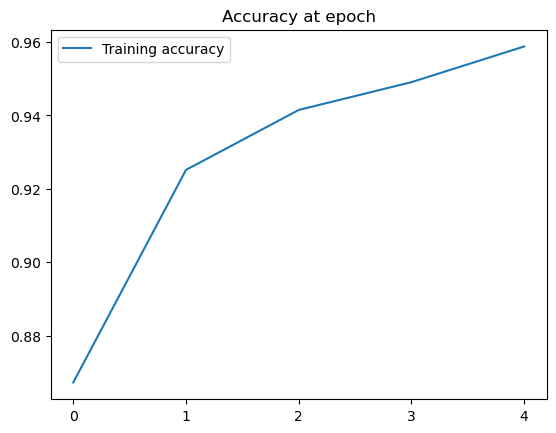

In [58]:
plt.plot([t[1].cpu().numpy()/5144 for t in train_correct], label = "Training accuracy")
plt.xticks(np.arange(5))
plt.title("Accuracy at epoch")
plt.legend()